In [1]:
library(tidyverse)

switchedYN = c("No" = "#91cf60", "Yes" = "#ef3b2c")

###################################
# Table reading and preprocessing #
###################################
get_psi <- function(sample_type, tumor = 'AML') {
    
    where <- ifelse(sample_type == 'Control', 'Primary tumor', 'Recurrent tumor')
    
    read_tsv(paste0('../data/expression/', tumor, '_', sample_type, '_isoform_tpm.tsv')) %>%
        gather(key = 'sample', value = 'tpm', -transcript) %>% 
        mutate(tpm = 2^tpm + .001, 
               where = factor(where, levels = c('Primary tumor', 'Recurrent tumor'))) %>%
        left_join(gene2tx, by = 'transcript') %>%
        group_by(gene, sample) %>%
        mutate(psi = tpm / sum(tpm)) %>%
        ungroup
}

###################################
#        Plotting functions       #
###################################
plot_expression <- function(gene) {
    switch <- filter(switches, Symbol == gene) %>% head(n = 1)
    samples <- strsplit(switch$Samples, ',') %>% unlist

    options(repr.plot.width=6, repr.plot.height=4)
    rbind(filter(ctrl, transcript %in% c(switch$Control_transcript, switch$Case_transcript)) %>% 
          select(transcript, sample, where, tpm),
          filter(case, transcript %in% c(switch$Control_transcript, switch$Case_transcript)) %>% 
          select(transcript, sample, where, tpm)) %>%
        mutate(switched = ifelse(sample %in% samples, 'Yes', 'No'),
               transcript = ifelse(transcript == switch$Case_transcript, 'Case', 'Control'),
               transcript = factor(transcript, levels = c('Control', 'Case'))) %>%
        ggplot(aes(x = transcript, y = log2(tpm), fill = switched)) +
            geom_boxplot() +
            scale_fill_manual(values = switchedYN) +
            facet_grid(. ~ where) +
            labs(x = 'Transcript', y = 'log2(TPM)', fill = 'Switch', title = gene) +
            theme(legend.position = 'bottom')
}

plot_psi <- function(gene) {
    switch <- filter(switches, Symbol == gene) %>% head(n = 1)
    samples <- strsplit(switch$Samples, ',') %>% unlist

    options(repr.plot.width=6, repr.plot.height=4)
    rbind(filter(ctrl, transcript %in% c(switch$Control_transcript, switch$Case_transcript)) %>% 
          select(transcript, sample, where, psi),
          filter(case, transcript %in% c(switch$Control_transcript, switch$Case_transcript)) %>% 
          select(transcript, sample, where, psi)) %>%
        mutate(switched = ifelse(sample %in% samples, 'Yes', 'No'),
               transcript = ifelse(transcript == switch$Case_transcript, 'Case', 'Control'),
               transcript = factor(transcript, levels = c('Control', 'Case'))) %>%
        ggplot(aes(x = transcript, y = psi, fill = switched)) +
            geom_boxplot() +
            scale_fill_manual(values = switchedYN) +
            facet_grid(. ~ where) +
            labs(x = 'Transcript', y = 'PSI', fill = 'Switch', title = gene) +
            theme(legend.position = 'bottom')
}

plot_dpsi <- function(gene) {
    
    switch <- filter(switches, Symbol == gene) %>% head(n = 1)
    samples <- strsplit(switch$Samples, ',') %>% unlist
    
    options(repr.plot.width=3, repr.plot.height=4)
    case %>%
        filter(transcript %in% c(switch$Control_transcript, switch$Case_transcript)) %>%
        select(transcript, sample, where, delta_psi) %>%
        mutate(switched = ifelse(sample %in% samples, 'Yes', 'No'),
               transcript = ifelse(transcript == switch$Case_transcript, 'Case', 'Control'),
               transcript = factor(transcript, levels = c('Control', 'Case'))) %>%
        ggplot(aes(x = transcript, y = delta_psi, fill = switched)) +
            geom_boxplot() +
            scale_fill_manual(values = switchedYN) +
            labs(x = 'Transcript', y = expression(Delta*'PSI'), fill = 'Switch', title = gene) +
            theme(legend.position = 'bottom')
    
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


In [2]:
tumor <- 'AML'

gene2tx <- read_csv('../data/tx2gene.csv', col_types = 'cc')
switches <- read_tsv(paste0('../results/', tumor, '/switches_final.tsv'), 
                     col_types = 'ccccciiiicc')

ctrl <- get_psi('Control', tumor)
median_ctrls <- ctrl %>%
    group_by(transcript) %>%
    summarize(median_ctrl = median(psi)) %>%
    ungroup

case <- get_psi('Case', tumor) %>%
    left_join(median_ctrls, by = 'transcript') %>%
    mutate(delta_psi = psi - median_ctrl)

Parsed with column specification:
cols(
  .default = col_double(),
  transcript = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  transcript = col_character()
)
See spec(...) for full column specifications.


In [3]:
head(switches)

Experiment,GeneId,Symbol,Control_transcript,Case_transcript,CDS_control,CDS_case,CDS_change,UTR_change,Samples,Driver
AML,ENSG00000197756.9,RPL37A,ENST00000456586.5,ENST00000491306.5,1,1,1,1,"TARGET-20-PAEDKB-04,TARGET-20-PAEFGT-04,TARGET-20-PAKERZ-04,TARGET-20-PAMYAS-04,TARGET-20-PARBIU-04,TARGET-20-PARDDY-04,TARGET-20-PARFAL-04,TARGET-20-PARUNX-04,TARGET-20-PARYFN-04,TARGET-20-PASCGR-04,TARGET-20-PASTUH-04,TARGET-20-PASVYA-04,TARGET-20-PASYJI-04",Driver interactor
AML,ENSG00000197756.9,RPL37A,ENST00000456586.5,ENST00000446558.5,1,1,1,1,TARGET-20-PARLVL-04,Driver interactor
AML,ENSG00000110700.6,RPS13,ENST00000525634.5,ENST00000228140.6,1,1,1,1,"TARGET-20-PAEDKB-04,TARGET-20-PAMYAS-04,TARGET-20-PARBIU-04,TARGET-20-PARDDY-04,TARGET-20-PARFAL-04,TARGET-20-PARUNX-04,TARGET-20-PARYFN-04,TARGET-20-PASTUH-04,TARGET-20-PASVVS-04,TARGET-20-PASVYA-04,TARGET-20-PASWAJ-04,TARGET-20-PASYJI-04",Driver interactor
AML,ENSG00000149806.10,FAU,ENST00000527548.5,ENST00000529639.5,1,1,0,1,"TARGET-20-PAKERZ-04,TARGET-20-PAMYAS-04,TARGET-20-PAPXRJ-04,TARGET-20-PARDDY-04,TARGET-20-PARUNX-04,TARGET-20-PASTUH-04,TARGET-20-PASVVS-04,TARGET-20-PASYJI-04",No
AML,ENSG00000149806.10,FAU,ENST00000279259.7,ENST00000527548.5,1,1,1,1,TARGET-20-PATDNN-04,No
AML,ENSG00000149806.10,FAU,ENST00000531743.5,ENST00000434372.2,1,1,1,1,TARGET-20-PATIAK-04,No


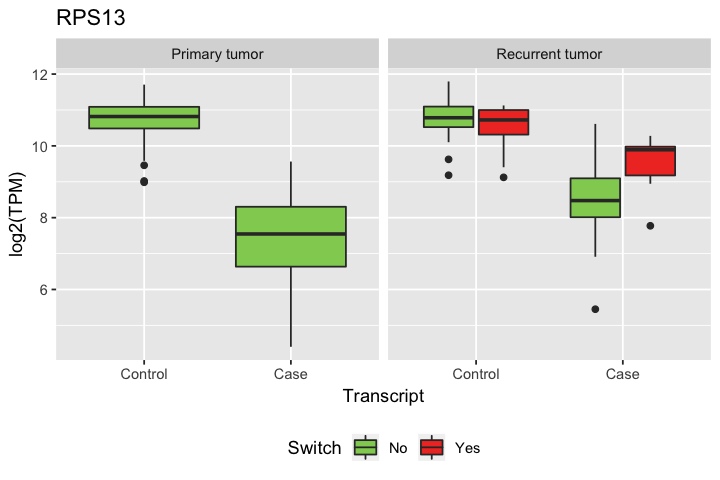

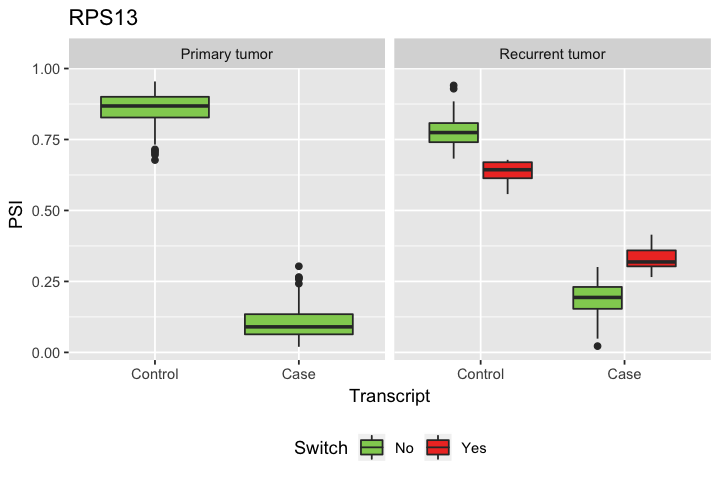

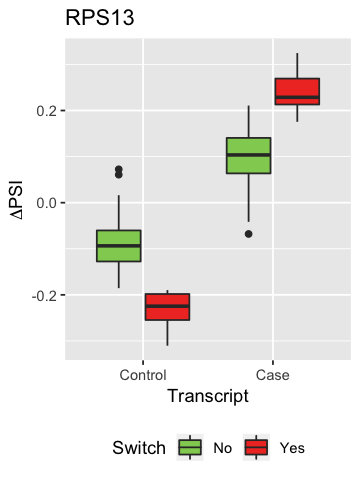

In [4]:
plot_expression('RPS13')
plot_psi('RPS13')
plot_dpsi('RPS13')

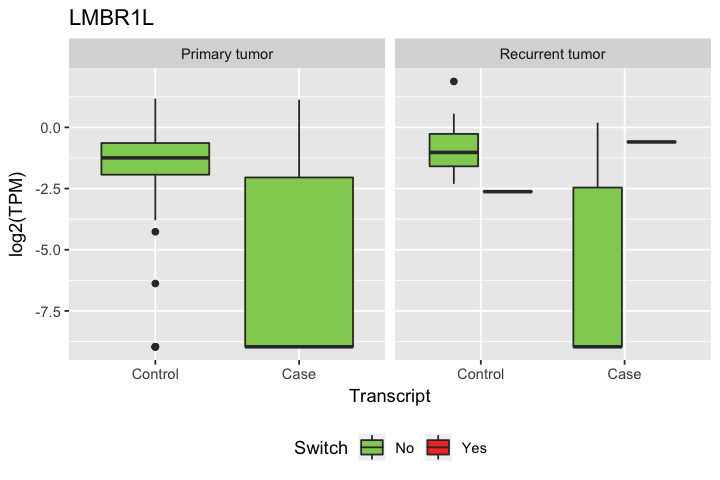

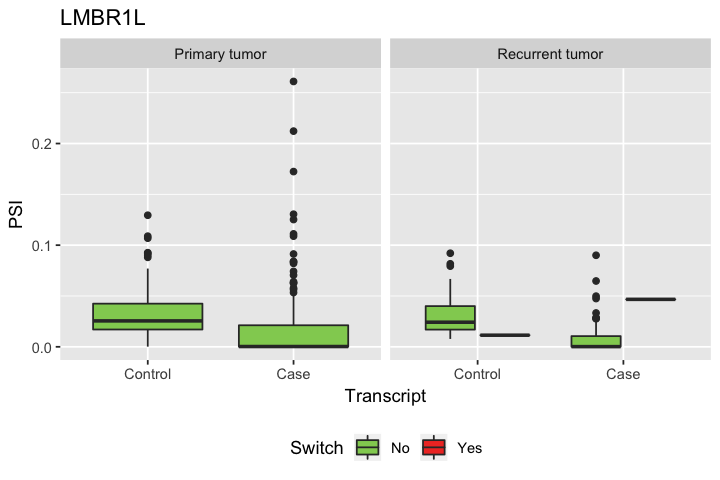

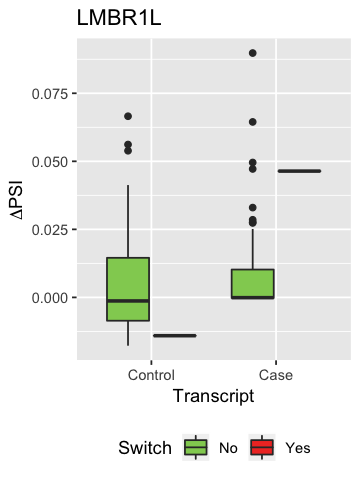

In [5]:
plot_expression('LMBR1L')
plot_psi('LMBR1L')
plot_dpsi('LMBR1L')

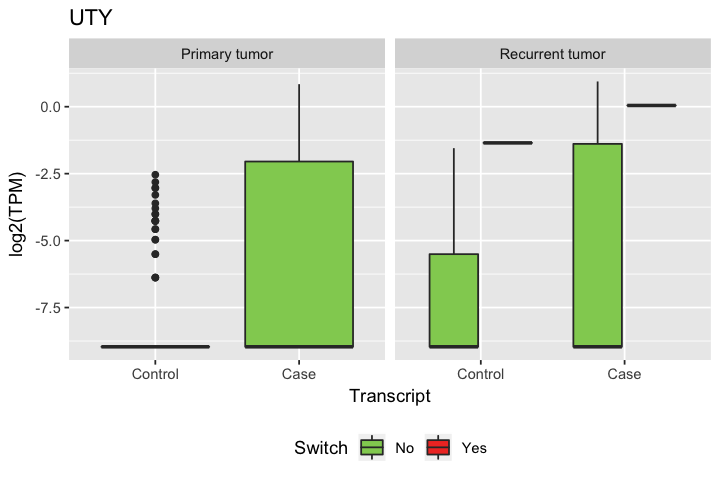

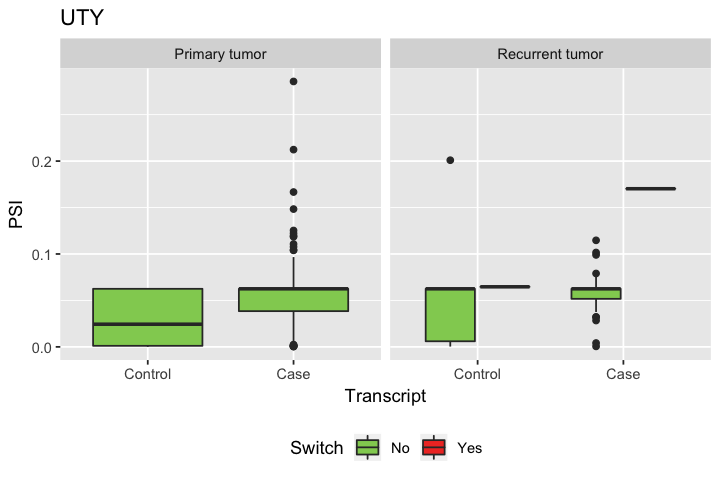

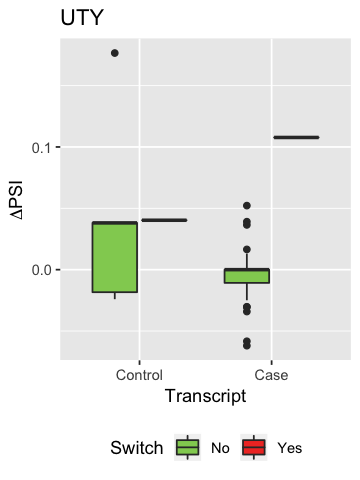

In [6]:
plot_expression('UTY')
plot_psi('UTY')
plot_dpsi('UTY')